In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import glob
import random
from tqdm import tqdm
from tqdm import trange
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
#import wandb
#wandb.init(project = "HC Assignment2")

In [ ]:
import random, os

##Added, Model Reproducibility
# Set the random seed to ensure reproducibility
seed = 42 
# Set the random seed for the Python interpreter
random.seed(seed)
# Set the random seed for hash values used in Python dictionaries
os.environ['PYTHONHASHSEED'] = str(seed)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed for PyTorch on CPU
torch.manual_seed(seed)
# Set the random seed for PyTorch on GPU (CUDA)
torch.cuda.manual_seed(seed)
# Set the flag to ensure that the computations on GPU are deterministic
torch.backends.cudnn.deterministic = True
# Set the flag to disable the automatic selection of the fastest algorithm for GPU computations
torch.backends.cudnn.benchmark = False

In [2]:
dirlist = ['TBX11K/imgs/health', 'TBX11K/imgs/tb']
classes = ['Healthy', 'tb']
filepaths = []
labels = []
for d, c in zip(dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  4600    labels:  4600


In [3]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=pd.DataFrame(np.array(df).reshape(4600,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

Healthy    3800
tb          800
Name: labels, dtype: int64


In [4]:
h_df = df[df['labels'] == 'Healthy']
h_df = h_df.sort_values('file_paths')

tb_df = df[df['labels'] == 'tb']
tb_df = tb_df.sort_values('file_paths')

In [7]:
tb_df.head(10)

,file_paths,labels
3800,TBX11K/imgs/tb\tb0003.png,tb
3801,TBX11K/imgs/tb\tb0004.png,tb
3802,TBX11K/imgs/tb\tb0005.png,tb
3803,TBX11K/imgs/tb\tb0006.png,tb
3804,TBX11K/imgs/tb\tb0007.png,tb
3805,TBX11K/imgs/tb\tb0009.png,tb
3806,TBX11K/imgs/tb\tb0012.png,tb
3807,TBX11K/imgs/tb\tb0014.png,tb
3808,TBX11K/imgs/tb\tb0015.png,tb
3809,TBX11K/imgs/tb\tb0017.png,tb


In [12]:
h_indix = int ( len(h_df.index) * 0.2)
tb_indix  = int ( len(tb_df.index) * 0.2)

In [13]:
h_test = h_df.iloc[0:h_indix]
h_train =  h_df.iloc[h_indix  :]

tb_test = tb_df.iloc[0:tb_indix]
tb_train =  tb_df.iloc[tb_indix  :]

In [21]:
tb_train

,file_paths,labels
3960,TBX11K/imgs/tb\tb0250.png,tb
3961,TBX11K/imgs/tb\tb0251.png,tb
3962,TBX11K/imgs/tb\tb0252.png,tb
3963,TBX11K/imgs/tb\tb0253.png,tb
3964,TBX11K/imgs/tb\tb0255.png,tb
...,...,...
4595,TBX11K/imgs/tb\tb1192.png,tb
4596,TBX11K/imgs/tb\tb1194.png,tb
4597,TBX11K/imgs/tb\tb1196.png,tb
4598,TBX11K/imgs/tb\tb1197.png,tb


In [17]:
train_df = pd.concat([h_train, tb_train])
test_df = pd.concat([h_test, tb_test])

In [8]:
train_df['file_paths'].iloc[0]

'TBX11K/imgs/health\\h0001.png'

In [9]:
X_train = train_df['file_paths']
X_test = test_df['file_paths']

Y_train = train_df['labels']
Y_test = test_df['labels']

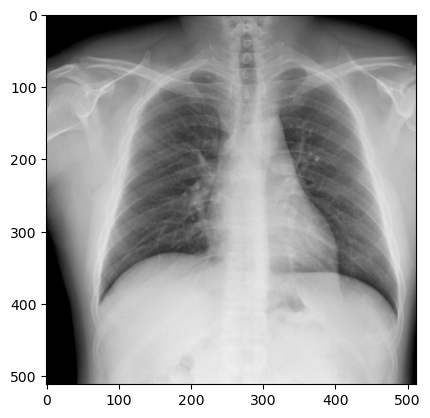

In [10]:
img = df.loc[1,"file_paths"]
img = plt.imread(img)
plt.imshow(img)

In [11]:
print(img.max())

0.95686275


In [36]:
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

# Load the dataframe
train_df = train_df

# Define the transformations
tb_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #transforms.CenterCrop((0.8, 0.8)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Define the transformations
healthy_transformations = transforms.Compose([
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Load the images and labels
images = []
labels = []

for i in range(len(train_df)):
    # Load the image
    image = Image.open(train_df['file_paths'].iloc[i])


    # Load and convert the label to tensor
    label_str = train_df['labels'].iloc[i]
    if label_str == 'Healthy':
        label = torch.tensor(0)
        # Apply the transformations
        image = healthy_transformations(image)
        # Append the image to the list
        images.append(image)
        
    elif label_str == 'tb':
        label = torch.tensor(1)
        # Apply the transformations
        image = tb_transformations(image)
        # Append the image to the list
        images.append(image)
    else:
        label = torch.tensor(-1)  # For unknown labels
    labels.append(label)

# Convert the images and labels to tensors
images = torch.stack(images)
labels = torch.stack(labels)

print(images.shape)
print(labels.shape)

dataset = TensorDataset(images, labels)

# Create a DataLoader
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

torch.Size([920, 3, 224, 224])
torch.Size([920])


In [61]:
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

# Load the dataframe
train_df = test_df


# Define the transformations
healthy_transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the images and labels
images = []
labels = []

for i in range(len(train_df)):
    # Load the image
    image = Image.open(train_df['file_paths'].iloc[i])

    # Load and convert the label to tensor
    label_str = train_df['labels'].iloc[i]
    if label_str == 'Healthy':
        label = torch.tensor(0)
        # Apply the transformations
        image = healthy_transformations(image)
        # Append the image to the list
        images.append(image)
        
    elif label_str == 'tb':
        label = torch.tensor(1)
        # Apply the transformations
        image = healthy_transformations(image)
        # Append the image to the list
        images.append(image)
    else:
        label = torch.tensor(-1)  # For unknown labels
    labels.append(label)

# Convert the images and labels to tensors
images = torch.stack(images)
labels = torch.stack(labels)

print(images.shape)
print(labels.shape)

dataset = TensorDataset(images, labels)

# Create a DataLoader
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=False)

torch.Size([920, 3, 224, 224])
torch.Size([920])


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [16]:

    
def calculate_f1_score(targets, preds):
    targets = targets.cpu().numpy()
    preds = preds.cpu().numpy()
    f1_scores = {}
    for cls in range(2):
        precision = precision_score(targets == cls, preds == cls)
        recall = recall_score(targets == cls, preds == cls)
        f1 = 2 * precision * recall / (precision + recall)
        f1_scores[cls] = {"precision": precision, "recall": recall, "f1": f1}
    return f1_scores


In [17]:
def train(model):
    model.train()
    train_loss = 0
    total = 0
    correct=0
    all_preds = []
    all_targets = []
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            # send to device
            data, target = data.to(device), target.to(device)
    
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            all_preds.append(predicted)
            all_targets.append(target)

            #wandb.log({'training_loss':train_loss/(batch_idx+1) , 'training_accuracy' :  100.*correct/total}, step=epoch)
        
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        f1_scores = calculate_f1_score(all_targets, all_preds)
        for cls, score_dict in f1_scores.items():
            print("F1 score for class {}: {:.4f}".format(cls, score_dict['f1']))
        
        print(' train loss: {:.4f} accuracy: {:.4f}'.format(train_loss/(batch_idx+1), 100.*correct/total))


In [18]:
def validate(model):   
    model.eval()

    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with tqdm(test_dataloader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            # send to device
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            all_preds.append(predicted)
            all_targets.append(target)
            #wandb.log({'test_loss':test_loss/(batch_idx+1) , 'test_accuracy' :  100.*correct/total}, step=epoch) 
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        f1_scores = calculate_f1_score(all_targets, all_preds)
        for cls, score_dict in f1_scores.items():
            print("F1 score for class {}: {:.4f}".format(cls, score_dict['f1']))

        print(' test loss: {:.4f} accuracy: {:.4f}'.format(test_loss/(batch_idx+1), 100.*correct/total))

In [39]:
import timm
#efficientnet_lite0
model = timm.create_model('efficientnet_lite0', num_classes=2, drop_rate = 0.7 pretrained=True)

In [40]:
sum(p.numel() for p in  model.parameters())

3373570

In [41]:
!pip install pip install ptflops
!pip install thop

In [42]:
import torch
import torchvision.models as models
from ptflops import get_model_complexity_info


# Specify the input tensor shape
input_shape = ( 3, 224, 224)

# Count the number of FLOPs for the model
flops_count, params_count = get_model_complexity_info(model, input_shape, print_per_layer_stat=False)

# Print the number of FLOPs and parameters for the model
print(f"Number of FLOPs: {flops_count}")
print(f"Number of parameters: {params_count}")


Number of FLOPs: 390.13 MMac
Number of parameters: 3.37 M


In [57]:
import torch
from thop import profile

model = model
#input_shape = (1, 3, 224, 224)
#input = torch.randn(*input_shape)
input = images

flops, params = profile(model, inputs=(input, ))
print(f"FLOPs: {flops}")


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 353256183040.0


In [24]:
model.cuda()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): InvertedR

In [25]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)
scedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=2, threshold=0.001, threshold_mode='abs')


epochs = 30

start = time.time()
for epoch in range(0, epochs):
    print("epoch number: {0}".format(epoch))
    train(model)
    validate(model)
    
end = time.time()
Total_time=end-start
print('Total training and inference time is: {0}'.format(Total_time))

epoch number: 0


100%|██████████| 115/115 [00:10<00:00, 11.39batch/s]


F1 score for class 0: 0.7122
F1 score for class 1: 0.3632
 train loss: 100.0316 accuracy: 60.3533


100%|██████████| 29/29 [00:00<00:00, 30.16batch/s]


F1 score for class 0: 0.8754
F1 score for class 1: 0.5977
 test loss: 0.6057 accuracy: 80.9783
epoch number: 1


100%|██████████| 115/115 [00:07<00:00, 15.29batch/s]


F1 score for class 0: 0.8180
F1 score for class 1: 0.5076
 train loss: 56.9510 accuracy: 73.4239


100%|██████████| 29/29 [00:00<00:00, 37.96batch/s]


F1 score for class 0: 0.9339
F1 score for class 1: 0.7263
 test loss: 0.3224 accuracy: 89.3478
epoch number: 2


100%|██████████| 115/115 [00:07<00:00, 14.65batch/s]


F1 score for class 0: 0.8917
F1 score for class 1: 0.6320
 train loss: 30.9366 accuracy: 83.2609


100%|██████████| 29/29 [00:00<00:00, 38.30batch/s]


F1 score for class 0: 0.9655
F1 score for class 1: 0.8262
 test loss: 0.2388 accuracy: 94.2391
epoch number: 3


100%|██████████| 115/115 [00:07<00:00, 14.50batch/s]


F1 score for class 0: 0.9336
F1 score for class 1: 0.7342
 train loss: 20.7233 accuracy: 89.3750


100%|██████████| 29/29 [00:00<00:00, 37.01batch/s]


F1 score for class 0: 0.9686
F1 score for class 1: 0.8256
 test loss: 0.2866 accuracy: 94.6739
epoch number: 4


100%|██████████| 115/115 [00:07<00:00, 15.54batch/s]


F1 score for class 0: 0.9452
F1 score for class 1: 0.7656
 train loss: 16.0544 accuracy: 91.1141


100%|██████████| 29/29 [00:00<00:00, 39.93batch/s]


F1 score for class 0: 0.9679
F1 score for class 1: 0.8214
 test loss: 0.3065 accuracy: 94.5652
epoch number: 5


100%|██████████| 115/115 [00:07<00:00, 15.43batch/s]


F1 score for class 0: 0.9638
F1 score for class 1: 0.8373
 train loss: 9.6995 accuracy: 94.0761


100%|██████████| 29/29 [00:00<00:00, 41.23batch/s]


F1 score for class 0: 0.9692
F1 score for class 1: 0.8298
 test loss: 0.2765 accuracy: 94.7826
epoch number: 6


100%|██████████| 115/115 [00:07<00:00, 15.48batch/s]


F1 score for class 0: 0.9699
F1 score for class 1: 0.8615
 train loss: 7.7399 accuracy: 95.0543


100%|██████████| 29/29 [00:00<00:00, 38.69batch/s]


F1 score for class 0: 0.9723
F1 score for class 1: 0.8502
 test loss: 0.2586 accuracy: 95.3261
epoch number: 7


100%|██████████| 115/115 [00:07<00:00, 15.45batch/s]


F1 score for class 0: 0.9755
F1 score for class 1: 0.8872
 train loss: 6.1122 accuracy: 95.9783


100%|██████████| 29/29 [00:00<00:00, 32.61batch/s]


F1 score for class 0: 0.9723
F1 score for class 1: 0.8491
 test loss: 0.2781 accuracy: 95.3261
epoch number: 8


100%|██████████| 115/115 [00:07<00:00, 15.40batch/s]


F1 score for class 0: 0.9796
F1 score for class 1: 0.9033
 train loss: 5.2611 accuracy: 96.6304


100%|██████████| 29/29 [00:00<00:00, 40.59batch/s]


F1 score for class 0: 0.9730
F1 score for class 1: 0.8531
 test loss: 0.2788 accuracy: 95.4348
epoch number: 9


100%|██████████| 115/115 [00:07<00:00, 15.31batch/s]


F1 score for class 0: 0.9825
F1 score for class 1: 0.9183
 train loss: 4.6308 accuracy: 97.1196


100%|██████████| 29/29 [00:00<00:00, 40.88batch/s]


F1 score for class 0: 0.9705
F1 score for class 1: 0.8369
 test loss: 0.3216 accuracy: 95.0000
epoch number: 10


100%|██████████| 115/115 [00:07<00:00, 14.99batch/s]


F1 score for class 0: 0.9842
F1 score for class 1: 0.9251
 train loss: 4.3833 accuracy: 97.3913


100%|██████████| 29/29 [00:00<00:00, 40.60batch/s]


F1 score for class 0: 0.9742
F1 score for class 1: 0.8611
 test loss: 0.2691 accuracy: 95.6522
epoch number: 11


100%|██████████| 115/115 [00:07<00:00, 15.00batch/s]


F1 score for class 0: 0.9842
F1 score for class 1: 0.9253
 train loss: 3.4827 accuracy: 97.3913


100%|██████████| 29/29 [00:00<00:00, 40.63batch/s]


F1 score for class 0: 0.9736
F1 score for class 1: 0.8561
 test loss: 0.2939 accuracy: 95.5435
epoch number: 12


100%|██████████| 115/115 [00:08<00:00, 13.96batch/s]


F1 score for class 0: 0.9863
F1 score for class 1: 0.9359
 train loss: 3.0321 accuracy: 97.7446


100%|██████████| 29/29 [00:00<00:00, 39.90batch/s]


F1 score for class 0: 0.9706
F1 score for class 1: 0.8345
 test loss: 0.3360 accuracy: 95.0000
epoch number: 13


100%|██████████| 115/115 [00:07<00:00, 14.96batch/s]


F1 score for class 0: 0.9885
F1 score for class 1: 0.9457
 train loss: 2.4021 accuracy: 98.0978


100%|██████████| 29/29 [00:00<00:00, 34.95batch/s]


F1 score for class 0: 0.9724
F1 score for class 1: 0.8481
 test loss: 0.2881 accuracy: 95.3261
epoch number: 14


100%|██████████| 115/115 [00:07<00:00, 15.20batch/s]


F1 score for class 0: 0.9908
F1 score for class 1: 0.9566
 train loss: 2.0267 accuracy: 98.4783


100%|██████████| 29/29 [00:00<00:00, 42.02batch/s]


F1 score for class 0: 0.9730
F1 score for class 1: 0.8511
 test loss: 0.2894 accuracy: 95.4348
epoch number: 15


100%|██████████| 115/115 [00:07<00:00, 14.95batch/s]


F1 score for class 0: 0.9923
F1 score for class 1: 0.9634
 train loss: 1.7525 accuracy: 98.7228


100%|██████████| 29/29 [00:00<00:00, 41.02batch/s]


F1 score for class 0: 0.9767
F1 score for class 1: 0.8767
 test loss: 0.2397 accuracy: 96.0870
epoch number: 16


100%|██████████| 115/115 [00:07<00:00, 15.21batch/s]


F1 score for class 0: 0.9918
F1 score for class 1: 0.9608
 train loss: 2.0517 accuracy: 98.6413


100%|██████████| 29/29 [00:00<00:00, 39.11batch/s]


F1 score for class 0: 0.9749
F1 score for class 1: 0.8632
 test loss: 0.2641 accuracy: 95.7609
epoch number: 17


100%|██████████| 115/115 [00:08<00:00, 14.27batch/s]


F1 score for class 0: 0.9944
F1 score for class 1: 0.9737
 train loss: 1.2230 accuracy: 99.0761


100%|██████████| 29/29 [00:00<00:00, 29.83batch/s]


F1 score for class 0: 0.9774
F1 score for class 1: 0.8797
 test loss: 0.2466 accuracy: 96.1957
epoch number: 18


100%|██████████| 115/115 [00:08<00:00, 14.30batch/s]


F1 score for class 0: 0.9924
F1 score for class 1: 0.9646
 train loss: 1.6364 accuracy: 98.7500


100%|██████████| 29/29 [00:00<00:00, 36.33batch/s]


F1 score for class 0: 0.9774
F1 score for class 1: 0.8789
 test loss: 0.2570 accuracy: 96.1957
epoch number: 19


100%|██████████| 115/115 [00:07<00:00, 14.70batch/s]


F1 score for class 0: 0.9956
F1 score for class 1: 0.9788
 train loss: 0.9084 accuracy: 99.2663


100%|██████████| 29/29 [00:00<00:00, 39.63batch/s]


F1 score for class 0: 0.9724
F1 score for class 1: 0.8470
 test loss: 0.3111 accuracy: 95.3261
epoch number: 20


100%|██████████| 115/115 [00:07<00:00, 14.75batch/s]


F1 score for class 0: 0.9957
F1 score for class 1: 0.9796
 train loss: 0.8662 accuracy: 99.2935


100%|██████████| 29/29 [00:00<00:00, 40.96batch/s]


F1 score for class 0: 0.9787
F1 score for class 1: 0.8874
 test loss: 0.2365 accuracy: 96.4130
epoch number: 21


100%|██████████| 115/115 [00:07<00:00, 14.91batch/s]


F1 score for class 0: 0.9936
F1 score for class 1: 0.9696
 train loss: 1.4153 accuracy: 98.9402


100%|██████████| 29/29 [00:00<00:00, 38.92batch/s]


F1 score for class 0: 0.9793
F1 score for class 1: 0.8912
 test loss: 0.2259 accuracy: 96.5217
epoch number: 22


100%|██████████| 115/115 [00:07<00:00, 15.01batch/s]


F1 score for class 0: 0.9957
F1 score for class 1: 0.9797
 train loss: 0.8976 accuracy: 99.2935


100%|██████████| 29/29 [00:00<00:00, 37.21batch/s]


F1 score for class 0: 0.9787
F1 score for class 1: 0.8874
 test loss: 0.2499 accuracy: 96.4130
epoch number: 23


100%|██████████| 115/115 [00:07<00:00, 14.58batch/s]


F1 score for class 0: 0.9952
F1 score for class 1: 0.9773
 train loss: 0.9924 accuracy: 99.2120


100%|██████████| 29/29 [00:00<00:00, 41.29batch/s]


F1 score for class 0: 0.9768
F1 score for class 1: 0.8750
 test loss: 0.2687 accuracy: 96.0870
epoch number: 24


100%|██████████| 115/115 [00:07<00:00, 15.01batch/s]


F1 score for class 0: 0.9967
F1 score for class 1: 0.9844
 train loss: 0.7634 accuracy: 99.4565


100%|██████████| 29/29 [00:00<00:00, 40.48batch/s]


F1 score for class 0: 0.9793
F1 score for class 1: 0.8904
 test loss: 0.2431 accuracy: 96.5217
epoch number: 25


100%|██████████| 115/115 [00:07<00:00, 15.02batch/s]


F1 score for class 0: 0.9964
F1 score for class 1: 0.9829
 train loss: 0.7015 accuracy: 99.4022


100%|██████████| 29/29 [00:00<00:00, 39.97batch/s]


F1 score for class 0: 0.9787
F1 score for class 1: 0.8874
 test loss: 0.2144 accuracy: 96.4130
epoch number: 26


100%|██████████| 115/115 [00:07<00:00, 15.26batch/s]


F1 score for class 0: 0.9970
F1 score for class 1: 0.9859
 train loss: 0.5805 accuracy: 99.5109


100%|██████████| 29/29 [00:00<00:00, 41.18batch/s]


F1 score for class 0: 0.9768
F1 score for class 1: 0.8750
 test loss: 0.2986 accuracy: 96.0870
epoch number: 27


100%|██████████| 115/115 [00:07<00:00, 14.93batch/s]


F1 score for class 0: 0.9979
F1 score for class 1: 0.9898
 train loss: 0.4852 accuracy: 99.6467


100%|██████████| 29/29 [00:00<00:00, 40.99batch/s]


F1 score for class 0: 0.9793
F1 score for class 1: 0.8904
 test loss: 0.2449 accuracy: 96.5217
epoch number: 28


100%|██████████| 115/115 [00:07<00:00, 15.09batch/s]


F1 score for class 0: 0.9972
F1 score for class 1: 0.9867
 train loss: 0.5729 accuracy: 99.5380


100%|██████████| 29/29 [00:00<00:00, 40.59batch/s]


F1 score for class 0: 0.9768
F1 score for class 1: 0.8750
 test loss: 0.2856 accuracy: 96.0870
epoch number: 29


100%|██████████| 115/115 [00:07<00:00, 14.91batch/s]


F1 score for class 0: 0.9980
F1 score for class 1: 0.9906
 train loss: 0.3602 accuracy: 99.6739


100%|██████████| 29/29 [00:00<00:00, 41.16batch/s]

F1 score for class 0: 0.9800
F1 score for class 1: 0.8942
 test loss: 0.2366 accuracy: 96.6304
Total training and inference time is: 256.330011844635


In [26]:
import numpy as np
import wandb
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_dataloader, device, class_names, normalize=False):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Log the confusion matrix to WandB
    fig = plt.gcf()
    wandb.log({'confusion_matrix': wandb.Image(fig)}, commit=False)

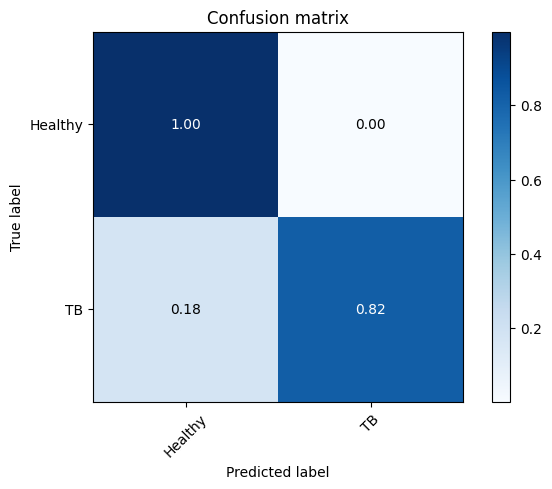

In [27]:
plot_confusion_matrix(model, test_dataloader, device, ['Healthy','TB'], normalize=True)